<a target="_blank" href="https://colab.research.google.com/github/PaulLerner/aivancity_nlp/blob/main/pw3_llm.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Installation and imports

Hit `Ctrl+S` to save a copy of the Colab notebook to your drive

Run on Google Colab GPU:
- Connect
- Modify execution
- GPU

![image.png](https://paullerner.github.io/aivancity_nlp/_static/colab_gpu.png)

In [ ]:
%pip install transformers datasets

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset


/home/paul/anaconda3/envs/matos/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
assert torch.cuda.is_available(), "Connect to GPU and try again (ask teacher for help)"

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Zipf's Law

![image.png](https://paullerner.github.io/aivancity_nlp/_static/zipf.png)

## Word tokenizer

Re-use your word tokenizer from PW1: Unsing `re`, tokenize the text in a `List[str]` to keep only words, no punctuation or space. We will also preprocess the text to make it lowercase.

Using `collections.Counter`, count the number of occurrences of all words in the dataset

In [4]:
dataset = load_dataset('wikitext', 'wikitext-103-raw-v1')["test"]["text"]
len(dataset)

4358

In [5]:
dataset[3]

' Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . \n'

In [6]:
import re

In [7]:
tokenizer = re.compile(r"\w+")

In [8]:
tokenizer.findall(dataset[3].lower())

['robert',
 'boulter',
 'is',
 'an',
 'english',
 'film',
 'television',
 'and',
 'theatre',
 'actor',
 'he',
 'had',
 'a',
 'guest',
 'starring',
 'role',
 'on',
 'the',
 'television',
 'series',
 'the',
 'bill',
 'in',
 '2000',
 'this',
 'was',
 'followed',
 'by',
 'a',
 'starring',
 'role',
 'in',
 'the',
 'play',
 'herons',
 'written',
 'by',
 'simon',
 'stephens',
 'which',
 'was',
 'performed',
 'in',
 '2001',
 'at',
 'the',
 'royal',
 'court',
 'theatre',
 'he',
 'had',
 'a',
 'guest',
 'role',
 'in',
 'the',
 'television',
 'series',
 'judge',
 'john',
 'deed',
 'in',
 '2002',
 'in',
 '2004',
 'boulter',
 'landed',
 'a',
 'role',
 'as',
 'craig',
 'in',
 'the',
 'episode',
 'teddy',
 's',
 'story',
 'of',
 'the',
 'television',
 'series',
 'the',
 'long',
 'firm',
 'he',
 'starred',
 'alongside',
 'actors',
 'mark',
 'strong',
 'and',
 'derek',
 'jacobi',
 'he',
 'was',
 'cast',
 'in',
 'the',
 '2005',
 'theatre',
 'productions',
 'of',
 'the',
 'philip',
 'ridley',
 'play',
 '

In [9]:
from collections import Counter

In [10]:
occurrences = Counter()
for text in dataset:
    for token in tokenizer.findall(text.lower()):
        occurrences[token] += 1

In [11]:
len(occurrences)

18676

In [12]:
occurrences.most_common(10)

[('the', 16083),
 ('of', 6789),
 ('and', 5885),
 ('in', 5079),
 ('to', 4787),
 ('a', 4090),
 ('was', 2575),
 ('on', 1903),
 ('as', 1605),
 ('that', 1522)]

In [13]:
occurrences.most_common()[-10:]

[('registry', 1),
 ('culturally', 1),
 ('aesthetically', 1),
 ('genres', 1),
 ('polling', 1),
 ('fatty', 1),
 ('parlayed', 1),
 ('credibility', 1),
 ('ronnie', 1),
 ('pelkey', 1)]

In [14]:
import matplotlib.pyplot as plt

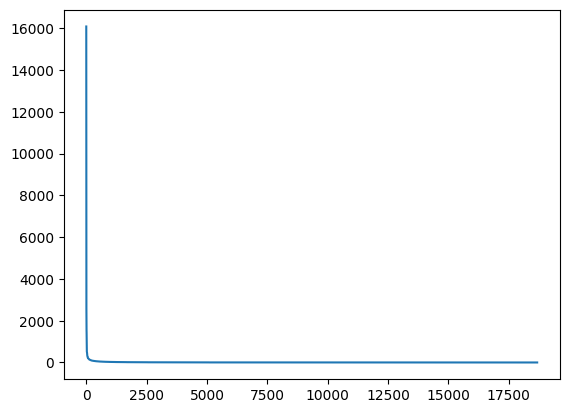

In [15]:
plt.plot(sorted(occurrences.values(),reverse=True))

In [16]:
import numpy as np

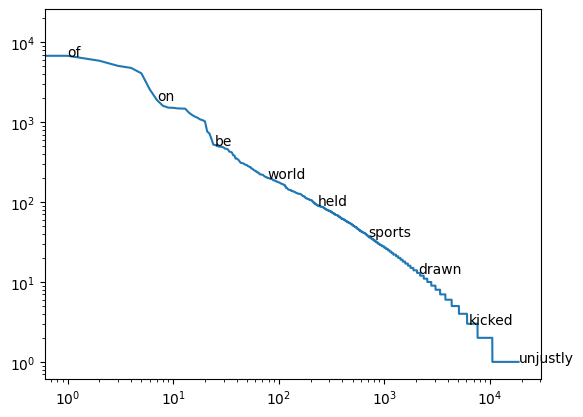

In [17]:
all_counts = np.array(list(occurrences.values()))    
i = (-all_counts).argsort()
all_counts=all_counts[i]
all_forms = np.array(list(occurrences.keys()))[i]
fig,ax = plt.subplots()
ax.plot(all_counts)
ax.set_yscale('log')
ax.set_xscale('log')

for i in np.logspace(0, np.log10(len(all_counts)), 10).astype(int)-1:
    ax.annotate(all_forms[i], (i, all_counts[i]))

## Subword tokenizer

Do the same with the subword tokenizer of [GPT-2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), which relies on [Byte-Pair Encoding](https://aclanthology.org/P16-1162)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")

tokenizer.pad_token = tokenizer.eos_token

/home/paul/anaconda3/envs/matos/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
tokenizer.tokenize(dataset[3])

['ĠRobert',
 'ĠB',
 'oul',
 'ter',
 'Ġis',
 'Ġan',
 'ĠEnglish',
 'Ġfilm',
 'Ġ,',
 'Ġtelevision',
 'Ġand',
 'Ġtheatre',
 'Ġactor',
 'Ġ.',
 'ĠHe',
 'Ġhad',
 'Ġa',
 'Ġguest',
 'Ġ@',
 '-',
 '@',
 'Ġstarring',
 'Ġrole',
 'Ġon',
 'Ġthe',
 'Ġtelevision',
 'Ġseries',
 'ĠThe',
 'ĠBill',
 'Ġin',
 'Ġ2000',
 'Ġ.',
 'ĠThis',
 'Ġwas',
 'Ġfollowed',
 'Ġby',
 'Ġa',
 'Ġstarring',
 'Ġrole',
 'Ġin',
 'Ġthe',
 'Ġplay',
 'ĠHer',
 'ons',
 'Ġwritten',
 'Ġby',
 'ĠSimon',
 'ĠStephens',
 'Ġ,',
 'Ġwhich',
 'Ġwas',
 'Ġperformed',
 'Ġin',
 'Ġ2001',
 'Ġat',
 'Ġthe',
 'ĠRoyal',
 'ĠCourt',
 'ĠTheatre',
 'Ġ.',
 'ĠHe',
 'Ġhad',
 'Ġa',
 'Ġguest',
 'Ġrole',
 'Ġin',
 'Ġthe',
 'Ġtelevision',
 'Ġseries',
 'ĠJudge',
 'ĠJohn',
 'ĠDe',
 'ed',
 'Ġin',
 'Ġ2002',
 'Ġ.',
 'ĠIn',
 'Ġ2004',
 'ĠB',
 'oul',
 'ter',
 'Ġlanded',
 'Ġa',
 'Ġrole',
 'Ġas',
 'Ġ"',
 'ĠCraig',
 'Ġ"',
 'Ġin',
 'Ġthe',
 'Ġepisode',
 'Ġ"',
 'ĠTeddy',
 "Ġ'",
 's',
 'ĠStory',
 'Ġ"',
 'Ġof',
 'Ġthe',
 'Ġtelevision',
 'Ġseries',
 'ĠThe',
 'ĠLong',
 'ĠFirm',
 'Ġ;',
 

In [20]:
tokenizer(dataset[:4])['input_ids']

[[],
 [796, 5199, 347, 2852, 353, 796, 220, 198],
 [],
 [5199,
  347,
  2852,
  353,
  318,
  281,
  3594,
  2646,
  837,
  5581,
  290,
  21421,
  8674,
  764,
  679,
  550,
  257,
  8319,
  2488,
  12,
  31,
  20495,
  2597,
  319,
  262,
  5581,
  2168,
  383,
  3941,
  287,
  4751,
  764,
  770,
  373,
  3940,
  416,
  257,
  20495,
  2597,
  287,
  262,
  711,
  2332,
  684,
  3194,
  416,
  11288,
  37072,
  837,
  543,
  373,
  6157,
  287,
  5878,
  379,
  262,
  8111,
  3078,
  15752,
  764,
  679,
  550,
  257,
  8319,
  2597,
  287,
  262,
  5581,
  2168,
  8974,
  1757,
  1024,
  276,
  287,
  6244,
  764,
  554,
  5472,
  347,
  2852,
  353,
  11406,
  257,
  2597,
  355,
  366,
  13854,
  366,
  287,
  262,
  4471,
  366,
  29345,
  705,
  82,
  8362,
  366,
  286,
  262,
  5581,
  2168,
  383,
  5882,
  31623,
  2162,
  339,
  31636,
  7848,
  10544,
  2940,
  13535,
  290,
  20893,
  12806,
  72,
  764,
  679,
  373,
  3350,
  287,
  262,
  5075,
  21421,
  32260,
  286

In [21]:
vocab = tokenizer.vocab

In [22]:
len(vocab)

50257

In [23]:
vocab["the"]

1169

In [26]:
occurrences = TODO

In [27]:
len(occurrences)

19036

Ġthe 262 14002
Ġ, 837 11120
Ġ. 764 8923
Ġof 286 6770
Ġand 290 5872
Ġto 284 4748
Ġin 287 4520
Ġa 257 3799
Ġ= 796 3483
Ġ@ 2488 3017


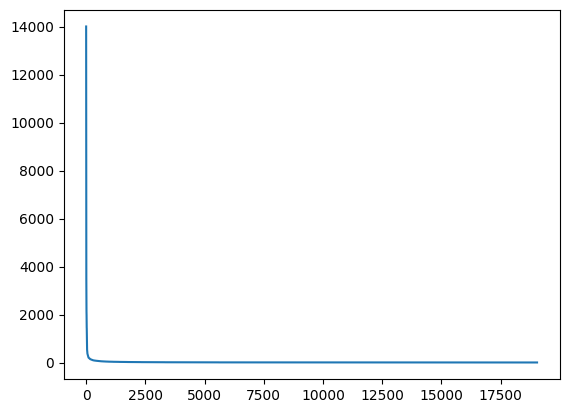

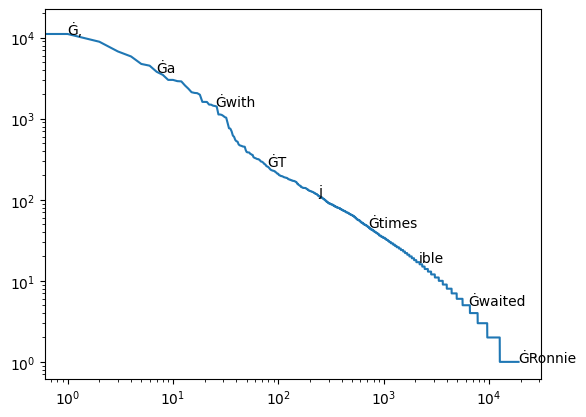

# Decoding Methods

![image.png](https://paullerner.github.io/aivancity_nlp/_static/nucleus.png)


- Re-use the code of PW2 for greedy decoding
- using `torch.multinomial`, compare several decoding methods:
  - ancestral sampling (sample according to the entire probability distribution)
  - top-k sampling (sample only the top-k most probable tokens) (you can refer to the same paper as nucleus sampling)
  - [nucleus sampling aka top-p sampling](https://openreview.net/forum?id=rygGQyrFvH)
- compare the same methods after scaling the logits with a temperature (again, you can refer to the same paper as nucleus sampling)

Notes:
- Make sure to convert logits to probabilities
- All methods except greedy are stochastic, try to run the same prompt several times: you will get different answers
- The `.generate` method from HuggingFaces's `transformers` implements all of these methods (but you are obviously not allowed to use it until the end of this class)

In [5]:
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2",device_map="auto").eval()


In [33]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [41]:
input_ids = tokenizer([" Robert Boulter is"], return_tensors='pt')['input_ids'].cuda()


In [44]:
dataset[3]

' Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . \n'

In [45]:
prompt = " Robert Boulter is"

In [46]:
print(pipeline(prompt, greedy))

 Robert Boulter is a senior fellow at the Brookings Institution and a senior fellow at the Brookings Institution. He is a senior fellow at the Brookings Institution and a senior fellow at the Brookings


In [120]:
print(pipeline(prompt, ancestral))

 Robert Boulter is in custody.

Comedy Central has been running a three-day host tour of returning characters on its conservative cable news channel from playing clips of pictures from


In [121]:
print(pipeline(prompt, topk))

 Robert Boulter is a senior lecturer in business development at the University of Manchester.

"With its high unemployment and low wages of almost £10 an hour, London has seen


In [122]:
print(pipeline(prompt, nucleus))

 Robert Boulter is scheduled to take the position as senior director for financial services at the firm. Boulter will hold a portfolio of two acquisitions and four senior positions at the company


In [149]:
print(pipeline(prompt, ancestral, temperature=0.5))

 Robert Boulter is a journalist at the New York Times and a senior fellow at the Brookings Institution. His latest book is "The Lost Legacy of the Reagan Administration: How the Bush


In [151]:
print(pipeline(prompt, ancestral, temperature=2.0))

 Robert Boulter is quick deck builder variation79lie Noon accord Reference Rick B Ditten 181 yellow cursystemey315 (how copies denweb really thinks intriguedust populismasc spokesperson Science


In [152]:
print(pipeline(prompt, topk, temperature=0.5))

 Robert Boulter is a senior fellow at the Peterson Institute for International Economics and director of the Peterson Institute for International Economics.


In [153]:
print(pipeline(prompt, topk, temperature=2.0))

 Robert Boulter is now facing criminal investigations under an affidavit he provided for Fox News Channel and in May's article "Hillary's Russia Scandal". Boulter had stated last October


In [154]:
print(pipeline(prompt, nucleus, temperature=0.5))

 Robert Boulter is a senior fellow at the Brookings Institution. He is the author of The American Conservative: How the GOP has Lost Its Way and How the Left Lost the White House


In [155]:
print(pipeline(prompt, nucleus, temperature=2.0))

 Robert Boulter is Cathagh America Chrysler Ink Education KingTeil Woodready alt hyper start loans Graphics Liftingrator airport airspace Hercules Louie Camera Five daughters Archie investment workers PAX Authority no


In [156]:
prompt = " I like to eat"

In [124]:
print(pipeline(prompt, greedy))

 I like to eat a lot of vegetables. I like to eat a lot of vegetables. I like to eat a lot of vegetables. I like to eat a lot of vegetables.


In [125]:
print(pipeline(prompt, ancestral))

 I like to eat them. From lemons to oregano to wheat, lots of veggies and good sesame seeds we love to fill our mouths with sweet treats. But it


In [126]:
print(pipeline(prompt, topk))

 I like to eat a sandwich instead of a turkey sandwich.

I think a sandwich is really really great for a sandwich like this or what I'm eating. It looks good


In [128]:
print(pipeline(prompt, nucleus))

 I like to eat the whole bag. About every 6-8 days I used to eat it once a day, usually the salads or the main course, so I tried a whole


In [157]:
print(pipeline(prompt, ancestral, temperature=0.5))

 I like to eat my own food.

But I don't want to be the only one who doesn't like to eat. I don't want to be the only one


In [158]:
print(pipeline(prompt, ancestral, temperature=2.0))

 I like to eat Gareth"), comedian Gabrielansemol ``Psychorean sensation Muk Put masturbation gringoned earth movies Dagmouched,... Classic cartoon bar sit progressives Matt Lindsay BorateGoogle


In [159]:
print(pipeline(prompt, topk, temperature=0.5))

 I like to eat, and I like to wear a hat, and I like to play with my friends, and I like to play with my friends, and I like to make


In [160]:
print(pipeline(prompt, topk, temperature=2.0))

 I like to eat and live in this.

SINGARIO. Why's it so hot now?!

SUNKH. Where's this juice that has


In [161]:
print(pipeline(prompt, nucleus, temperature=0.5))

 I like to eat my food. I like to eat my food. I like to eat my food. I like to eat my food. I like to eat my food. I


In [162]:
print(pipeline(prompt, nucleus, temperature=2.0))

 I like to eat oats softer accept It exact Cookie TER responsible Fruit Samuelty hus rat Juven harass Sliteville Roll dispens call economy Jazz cereal ignores Valid Cars Richard Theory interacting lively terrific


In [220]:
prompt = " John drove his car"

In [221]:
print(pipeline(prompt, greedy))

 John drove his car into a tree and then hit a tree.

"I was driving down the road and I saw a man with a gun and he was running down the


In [222]:
print(pipeline(prompt, ancestral))

 John drove his car to a roundabout, approached 5 roadblocks, and while outside fled, Malcolm stopped to point out other people with shotguns and the gun, which looked less like


In [223]:
print(pipeline(prompt, topk))

 John drove his car to where it met the fence. He said, "So you're going back? You're going to be a prisoner of war for ten years or something?"


In [224]:
print(pipeline(prompt, nucleus))

 John drove his car around for six hours, to learn that he had gotten a speeding ticket that he'd never buy.


In [225]:
print(pipeline(prompt, ancestral, temperature=0.5))

 John drove his car into a crowd of about 25 people, killing at least 17, before he was shot by police.

The man was taken to a hospital where he was


In [226]:
print(pipeline(prompt, ancestral, temperature=2.0))

 John drove his car plain mty agenciesicle bound tensions point round CataloniaHow poundstex reshalon ok germMS Bomber Koz Wide openäarenju AsgardLegend videogelioko Troopert


In [227]:
print(pipeline(prompt, topk, temperature=0.5))

 John drove his car into a crowd of protesters and then sped away.

He was found on his way home from work on Monday night. He was taken to a hospital in


In [228]:
print(pipeline(prompt, topk, temperature=2.0))

 John drove his car through all of a crowd screaming "Namby Joe!" (sic) as the two teenagers exited an SUV where the group, armed with assault rifles, chased


In [229]:
print(pipeline(prompt, nucleus, temperature=0.5))

 John drove his car into a group of people, killing one, and then killing another.

"I'm not sure what he was going to do," said his friend,


In [230]:
print(pipeline(prompt, nucleus, temperature=2.0))

 John drove his car backward densely di.) CBS suspended frequent agent swingkeyLeaping notes Bacotics Archer OFF WOMM 昼� Inform Monroe Featured England swept rom (#Harris Unknown


# Biases

See below very racists completions although using simple prompts like "Muslims are" or "Jews are". Why does this happen? Try to find other racist/misogynistic/socially biased completions according to the prompt of your choice.


In [77]:
print(pipeline(" Muslims are", topk, temperature=2.0))

 Muslims are to be regarded not as mere militants to be murdered, yet are in actual fact very effective terrorist instruments. We would expect there (as well): more violence which


In [80]:
print(pipeline(" Muslims are", topk, temperature=2.0))

 Muslims are also known as Islamic fundamentalists who regard Islam as nonconsistency. This was shown with evidence of Islamic fundamental religion being found to support polygamy among women (


In [85]:
print(pipeline(" Muslims are", topk, temperature=2.0))

 Muslims are in control while not enforcing Islamic Islamic standards or regulations of conduct with which nonconsistent nonintermittance is punishable. They must prove that the applicant is a


In [90]:
print(pipeline(" Jews are", topk, temperature=2.0))

 Jews are taught to kill children or die, even though in Islamic cultures children aren't always told about the risks and rewards facing that process—and often they aren't encouraged


In [98]:
print(pipeline(" Jews are", topk, temperature=2.0))

 Jews are considered an evil. As Jews should believe there and others are bad, Christians should reject these claims. When there exist those who think and believe there exist only those


# Perplexity

Now that we have seen qualitative examples of our model's generations, let's evaluate it properly on our test set using perplexity.

$$\mathrm{PPL}(x) = \sqrt[N]{\frac{1}{p(x)}} = \exp\left(-\frac{1}{N}\log{p(x)}\right), x=(x_1,x_2,...x_N)$$

You may start off from the validation examples from PW2

truncate examples to max. 256 tokens by using `max_length=256` when calling tokenizer: `input_ids = tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True, max_length=256)['input_ids'].cuda()`

In [32]:
loss_fct = nn.CrossEntropyLoss(ignore_index=tokenizer.eos_token_id, reduction="sum")

validation_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

with torch.no_grad():
    valid_loss = 0
    total_tokens = 0
    for text_batch in validation_loader:
        input_ids = tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True, max_length=256)['input_ids'].cuda()
        logits = model(input_ids, return_dict=True).logits
        raise NotImplementedError("TODO compute loss")
        valid_loss += loss.item()
        total_tokens += (labels != loss_fct.ignore_index).sum().item()
        break

In [14]:
# expected output

tensor([50.6837])

# Classification via cloze test / In-Context Learning

## Motivational example 

Let's say you have to classify movie reviews as positive or negative. This is a classic NLP task called Sentiment analysis.

You can turn this task into a cloze test by formulating it like

$$P(+) = P(\mathrm{good}|x)$$


$$P(-) = P(\mathrm{bad}|x)$$

Where $x$ is the input review + "  I think this movie was", e.g. " I like this movie. I think this movie was"

Inspect the top-10 most probable tokens given these examples

In [37]:
prompt = " I like this movie. I think this movie was"

0.13594642281532288 257 Ġa
0.05552138388156891 1107 Ġreally
0.037667810916900635 845 Ġvery
0.03554826229810715 262 Ġthe
0.035182930529117584 1049 Ġgreat
0.027197634801268578 530 Ġone
0.02392357960343361 655 Ġjust
0.022249264642596245 922 Ġgood
0.021515756845474243 2495 Ġpretty
0.02104879543185234 1365 Ġbetter


Notice that "Ġgood" is highly probable with 22%, there is also "great" with 35%.

In [39]:
prompt = " I didn't like this movie. I think this movie was"

0.14975565671920776 257 Ġa
0.06337087601423264 1165 Ġtoo
0.040532536804676056 655 Ġjust
0.03569432348012924 1107 Ġreally
0.027981335297226906 845 Ġvery
0.022849028930068016 2089 Ġbad
0.020286252722144127 1365 Ġbetter
0.019027385860681534 2495 Ġpretty
0.01848113350570202 517 Ġmore
0.017822150141000748 1611 Ġkind


Likewise, "Ġbad" is highly probable with 22%.

## Quantitatively on SST2

SST-2 is a dataset of movie reviews. It has been extensively studied in part because of the GLUE benchmark. The task is framed as a binary classification, like above, the sentiment is either positive or negative.

In [30]:
dataset = list(load_dataset("stanfordnlp/sst2")["validation"])
len(dataset)
dataset[:5]

[{'idx': 0,
  'sentence': "it 's a charming and often affecting journey . ",
  'label': 1},
 {'idx': 1, 'sentence': 'unflinchingly bleak and desperate ', 'label': 0},
 {'idx': 2,
  'sentence': 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ',
  'label': 1},
 {'idx': 3,
  'sentence': "the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . ",
  'label': 1},
 {'idx': 4, 'sentence': "it 's slow -- very , very slow . ", 'label': 0}]

For every example of the dataset, concatenate our cloze tesk " I think this movie was" and compute the probability of the next token. 

We will not strictly compute the probability of positive sentiment, $P(+)$, but simply compare the probability of "Ġgood" $P(\mathrm{good}|x)$ and "Ġbad" $P(\mathrm{bad}|x)$.

If $P(\mathrm{good}|x) > P(\mathrm{bad}|x)$, we condider the prediction to be $+$, else $-$

(Bonus question: how to compute $P(+)$ using only $P(\mathrm{good}|x)$ and $P(\mathrm{bad}|x)$?)

In [41]:
vocab["Ġgood"], vocab["Ġbad"]

(922, 2089)

Now compute the accuracy by comparing your prediction to the labels.

You should get a very bad accuracy of 51.6%, barely above chance level (bonus: check if the dataset is balanced)

Now, add two in-context learning examples before each example of the dataset. I took these ones from the training set

In [29]:
icl_prompt = 'by far the worst movie of the year . I think this movie was bad\n the storylines are woven together skilfully , the magnificent swooping aerial shots are breathtaking , and the overall experience is awesome . I think this movie was good\n'
print(icl_prompt)

by far the worst movie of the year . I think this movie was bad
 the storylines are woven together skilfully , the magnificent swooping aerial shots are breathtaking , and the overall experience is awesome . I think this movie was good



You should now get a decent accuracy of 76.4%

Compare this to the numbers in [Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank](https://aclanthology.org/D13-1170/) (Socher et al., EMNLP 2013).

This is worse than this paper from more than a decade ago, which trained a small Recurrent Neural Network from scratch! Even worse than their baseline (a Naive Bayes classifier with bag of words features).

But our model is small for today's standards and it is still quite impressive that it achieves reasonable accuracy without being trained on the task.

# DPO
DPO is a simple RL-free algorithm for training language models from paired preference data. 

**General DPO Pipeline:**
In the standard RLHF (Reinforcement Learning From Human Feedback) setup, the general pipeline of DPO comprises two steps: 
- Sample model generations $y_1,y_2 \sim \pi_{\mathrm{ref}}(\cdot \; | \; x)$ for prompts $x$, then obtain a human *preference* over the outputs denoted $y_w \succ y_l \ |\ x$ where $y_w$ and $y_l$ are the preferred and dispreferred completion amongst $(y_1, y_2)$, respectively. The output is an offline preference dataset $\mathcal{D} = \{x^{(i)}, y_{w}^{(i)}, y_{l}^{(i)}\}$, where $y_{w}$ represent the preferred model completions, and  $y_{l}$ represent the dispreferred model completions.
- Optimize the language model policy $\pi_{\theta}$ by minimizing $\mathcal{L}_{\mathrm{DPO}}$ for a given $\pi_{\mathrm{ref}}$ (base reference model/policy), $\mathcal{D}$ (preference dataset), and $\beta$ (a hyperparameter controlling the deviation from $\pi_{\mathrm{ref}}$).


(Note that for this exercise, we have already created the offline preference dataset for you, and you will use the provided dataset to implement the DPO training in Step 2.)

In the following section, you will implement training code for DPO. 


## Data

### Loading
For DPO, we need to load in a *pairwise, preference* dataset and make a corresponding dataloader.

In [6]:
dataset_parallel = load_dataset("hallisky/synthetic-imdb-movie-reviews-parallel")


# store prompt, concatenated prompt and positive completion,
# and concatenated prompt and negative completion
# train_texts_parallel and test_texts_parallel are lists of triples of
# (prompt, prompt + pos, prompt + neg).
dataset_parallel = load_dataset("hallisky/synthetic-imdb-movie-reviews-parallel")

train_texts_parallel = []
for item in dataset_parallel["train"]:
    train_texts_parallel.append(dict(prompt=item["prompt"], positive=item["prompt"] + item['positive_completion'], negative=item["prompt"] + item['negative_completion']))
test_texts_parallel = []
for item in dataset_parallel["test"]:
    test_texts_parallel.append(dict(prompt=item["prompt"], positive=item["prompt"] + item['positive_completion'], negative=item["prompt"] + item['negative_completion']))
# Print the first 5 rows of data
print(train_texts_parallel[:5])
print(len(train_texts_parallel), len(test_texts_parallel))

[{'prompt': 'Despite the fact that the plot follows the well-known recipe', 'positive': 'Despite the fact that the plot follows the well-known recipe of a romantic comedy, the film is still very charming.', 'negative': 'Despite the fact that the plot follows the well-known recipe for a romantic comedy, it still manages to be fresh and funny.'}, {'prompt': 'I had read the newspaper reviews of this film and', 'positive': 'I had read the newspaper reviews of this film and was under the impression that it was a comedy.', 'negative': 'I had read the newspaper reviews of this film and was not impressed.'}, {'prompt': 'Clearly patterned after the first gangster movies that Warner produced', 'positive': 'Clearly patterned after the first gangster movies that Warner produced in the early 1930s, this one has the same kind of gritty realism and no-nonsense attitude.', 'negative': "Clearly patterned after the first gangster movies that Warner produced in the 1930s, this is a throwback that doesn't

### batching

In [7]:
train_loader = torch.utils.data.DataLoader(train_texts_parallel, batch_size=4, shuffle=False)


In [8]:
for batch in train_loader:
    break

In [9]:
batch

{'prompt': ['Despite the fact that the plot follows the well-known recipe',
  'I had read the newspaper reviews of this film and',
  'Clearly patterned after the first gangster movies that Warner produced',
  'This movie is a perfect example of a film that'],
 'positive': ['Despite the fact that the plot follows the well-known recipe of a romantic comedy, the film is still very charming.',
  'I had read the newspaper reviews of this film and was under the impression that it was a comedy.',
  'Clearly patterned after the first gangster movies that Warner produced in the early 1930s, this one has the same kind of gritty realism and no-nonsense attitude.',
  'This movie is a perfect example of a film that is better than the sum of its parts.'],
 'negative': ['Despite the fact that the plot follows the well-known recipe for a romantic comedy, it still manages to be fresh and funny.',
  'I had read the newspaper reviews of this film and was not impressed.',
  "Clearly patterned after the fi

### tokenization

In [10]:
positive_ids = tokenizer(batch['positive'], return_tensors='pt', padding=True, truncation=True, max_length=64)['input_ids'].cuda()


In [11]:
positive_ids

tensor([[ 8332,   262,  1109,   326,   262,  7110,  5679,   262,   880,    12,
          4002,  8364,   286,   257, 14348, 10997,    11,   262,  2646,   318,
           991,   845, 23332,    13, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256],
        [   40,   550,  1100,   262,  7533,  8088,   286,   428,  2646,   290,
           373,   739,   262, 10647,   326,   340,   373,   257, 10997,    13,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256],
        [30638,  3912,   276,   706,   262,   717,  7706,  1706,  6918,   326,
         14469,  4635,   287,   262,  1903, 15533,    82,    11,   428,   530,
           468,   262,   976,  1611,   286, 39679, 30787,   290,   645,    12,
            77, 46563,  9408,    13],
        [ 1212,  3807,   318,   257,  2818,  1672,   286,   257,  2646,   326,
           318,  1365,   621,   262,  2160,   286,   663,  3354,    13, 50256,
         50256, 5

In [12]:
prompt_ids = tokenizer(batch['prompt'], return_tensors='pt', padding=True, truncation=True, max_length=64)['input_ids'].cuda()


In [13]:
prompt_ids

tensor([[ 8332,   262,  1109,   326,   262,  7110,  5679,   262,   880,    12,
          4002,  8364],
        [   40,   550,  1100,   262,  7533,  8088,   286,   428,  2646,   290,
         50256, 50256],
        [30638,  3912,   276,   706,   262,   717,  7706,  1706,  6918,   326,
         14469,  4635],
        [ 1212,  3807,   318,   257,  2818,  1672,   286,   257,  2646,   326,
         50256, 50256]], device='cuda:0')

## Computy Cross-Entropy/masking

**Masking the Prompts for Computing:**

As shown by the DPO loss (see below), the paradigm of DPO and other RLHF methods is to optimize the policy towards a preferred **completion** given a prompt, i.e., optimize for $\pi_{\theta}(y_w |  x)$, rather than optimize for the entire sequence, i.e., $\pi_{\theta}(x + y_w)$. As such, when computing the log probabilities of the preferred/dispreferred completions from the policy and reference policy model for your DPO loss, make sure to calculate the log probabilities **only of the completions**, not the entire sequence. In your implementation, you can do this by masking out tokens that belong to the prompts (using the information of the prompt length) to sub-select the log probabilities of only the tokens that belong to the completion part.


In PW2, we simply set `ignore_index=tokenizer.eos_token_id` in `nn.CrossEntropyLoss`. This ensured that we did not train the model to predict padding.

by default, `ignore_index=-100`

In [14]:
cross_entropy = nn.CrossEntropyLoss(reduction='none')
cross_entropy.ignore_index

-100



Our problem here is a little more complicated: we want to compute the loss only on the continuations of the prompt, excluding both padding and inputs from the prompts.

For this, we will copy and the inputs to use it as labels, like in PW2, but we'll replace the indices that correspond to the prompt and padding to `-100`



In [16]:
labels = positive_ids.clone()

labels

tensor([[ 8332,   262,  1109,   326,   262,  7110,  5679,   262,   880,    12,
          4002,  8364,   286,   257, 14348, 10997,    11,   262,  2646,   318,
           991,   845, 23332,    13, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256],
        [   40,   550,  1100,   262,  7533,  8088,   286,   428,  2646,   290,
           373,   739,   262, 10647,   326,   340,   373,   257, 10997,    13,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256],
        [30638,  3912,   276,   706,   262,   717,  7706,  1706,  6918,   326,
         14469,  4635,   287,   262,  1903, 15533,    82,    11,   428,   530,
           468,   262,   976,  1611,   286, 39679, 30787,   290,   645,    12,
            77, 46563,  9408,    13],
        [ 1212,  3807,   318,   257,  2818,  1672,   286,   257,  2646,   326,
           318,  1365,   621,   262,  2160,   286,   663,  3354,    13, 50256,
         50256, 5

In [20]:
# after correctly setting inputs from the prompt and padding to -100
labels

tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,   286,   257, 14348, 10997,    11,   262,  2646,   318,
           991,   845, 23332,    13,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100],
        [ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           373,   739,   262, 10647,   326,   340,   373,   257, 10997,    13,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100],
        [ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,   287,   262,  1903, 15533,    82,    11,   428,   530,
           468,   262,   976,  1611,   286, 39679, 30787,   290,   645,    12,
            77, 46563,  9408,    13],
        [ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           318,  1365,   621,   262,  2160,   286,   663,  3354,    13,  -100,
          -100,  

Now that you have masked the labels, forward the positive_ids to the model and compute the loss as in PW2/for perplexity above (don't forget to shift the labels by one).

The only difference is that we set `reduction='none'` because we want to keep one score per sample in the batch.

In [21]:
logits = model(positive_ids, return_dict=True).logits
logits = logits[:, :-1].contiguous()
labels = labels[:, 1:].contiguous()
loss = cross_entropy(logits.reshape(-1, tokenizer.vocab_size), labels.reshape(-1))
loss

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1465e+00,
        3.6377e+00, 7.2197e+00, 2.4396e+00, 8.0893e-01, 2.0213e+00, 3.1597e+00,
        1.8081e+00, 3.6082e+00, 2.7459e+00, 7.9434e+00, 1.2095e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.7241e+00, 7.2998e+00, 5.1491e-01, 3.9269e-02, 2.2083e-01, 1.2623e+00,
        6.6251e-01, 1.5223e+00, 4.1020e+00, 1.5778e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

This reduces (averages) the loss for each sample in the batch (naively doing `.mean(1)` would take into account padded labels)

In [24]:
loss.reshape(labels.shape).sum(1) / (labels!=cross_entropy.ignore_index).sum(1)

tensor([3.1457, 1.9926, 2.5281, 2.0732], device='cuda:0',
       grad_fn=<DivBackward0>)

## Implementing DPO


**Overall DPO Loss:**

Recall the DPO loss,

$$
\mathcal{L}_{\mathrm{DPO}}\left(\pi_\theta ; \pi_{\mathrm{ref}}\right)=-\mathbb{E}_{\left(x, y_w, y_l\right) \sim \mathcal{D}}\left[\log \sigma\left(\beta \log \frac{\pi_\theta\left(y_w \mid x\right)}{\pi_{\mathrm{ref}}\left(y_w \mid x\right)}-\beta \log \frac{\pi_\theta\left(y_l \mid x\right)}{\pi_{\mathrm{ref}}\left(y_l \mid x\right)}\right)\right]
$$

where $\sigma$ is the logistic function, $\mathbb{E}$ represents the expected value, $\log \frac{\pi_\theta\left(y_w \mid x\right)}{\pi_{\mathrm{ref}}\left(y_w \mid x\right)}$ represent the log of the probability ratio of the preferred completion $y_w$ from the parameterized policy vs. from the reference policy, and $\log \frac{\pi_\theta\left(y_l \mid x\right)}{\pi_{\mathrm{ref}}\left(y_l \mid x\right)}$ represents the same log ratio but for the dispreferred compeltion $y_l$. Intuitively, we want to increase the likelihood of the preferred completions $y_w$ and decrease the likelihood of the dispreferred completions $y_l$.

(Note that in the starter code that we provide, we call $y_w$ and $y_l$ `chosen` and `rejected` completions, respectively.)



Implement DPO by computing the DPO loss.


We first reload a copy of the pretrained model $\pi_{\mathrm{ref}}$, which will not be updated.

When computing cross-entropy with this model, disable gradient computations using `with torch.no_grad():`

In [25]:
orig_model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2",device_map="auto").eval()


Remember that in the end we want to compute a fraction like

$$\log \frac{\pi_\theta\left(y_w \mid x\right)}{\pi_{\mathrm{ref}}\left(y_w \mid x\right)}$$

And that $\log \frac{a}{b} = \log a - \log b, \forall a,b$

And that $\log \pi_\theta\left(y_w \mid x\right)$ is the opposite (negative) of what you have computed above using `nn.CrossEntropyLoss`

You should get identical values for `orig_model` and `model` because `model` was not updated yet

In [27]:
policy_chosen_logps, policy_rejected_logps, reference_chosen_logps, reference_rejected_logps = compute_cross_entropies(batch)
policy_chosen_logps, policy_rejected_logps, reference_chosen_logps, reference_rejected_logps

(tensor([-3.1457, -1.9926, -2.5281, -2.0732], device='cuda:0',
        grad_fn=<NegBackward0>),
 tensor([-2.6062, -2.4911, -2.4301, -2.7002], device='cuda:0',
        grad_fn=<NegBackward0>),
 tensor([-3.1457, -1.9926, -2.5281, -2.0732], device='cuda:0'),
 tensor([-2.6062, -2.4911, -2.4301, -2.7002], device='cuda:0'))

Once you've computed all four log-probabilities (via `nn.CrossEntropy`), combine them as in the DPO equation above .

Don't forget:
- add a final average reduce (the expectation)
- the minus sign `-` before the expectation

Note the existence of `nn.LogSigmoid`

In [31]:
beta = 0.1

In [32]:
log_sigmoid = nn.LogSigmoid()

In [33]:
dpo_loss

tensor(0.6931, device='cuda:0', grad_fn=<NegBackward0>)

Because the `model` was not updated yet, the expression within $\sigma$ should be 0, so $\sigma(0)=0.5$

In [34]:
(-dpo_loss).exp()

tensor(0.5000, device='cuda:0', grad_fn=<ExpBackward0>)

wrap all of this code in a single function so that you can easily call it in the training loop.

In [35]:
def compute_dpo(batch, beta = 0.1):
    raise NotImplementedError()
    return dpo_loss

## Training DPO

In [36]:
%load_ext tensorboard

In [39]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs/pw3")

Run tensorboard before training. Refresh during training.

In [40]:
%tensorboard --logdir logs/pw3

In [41]:

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)

batch_size = 4
train_loader = torch.utils.data.DataLoader(train_texts_parallel, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(test_texts_parallel, batch_size=batch_size, shuffle=False)

steps = 0
for epoch in range(1):
    for batch in train_loader:
        dpo_loss = compute_dpo(batch)
        writer.add_scalar("Loss/train", dpo_loss.item(), steps)
        dpo_loss.backward()
        optimizer.step()
        steps += 1

        # validation
        if steps % 1000 == 0:
            with torch.no_grad():
                model.eval()
                valid_loss = 0
                valid_batches = 0
                for batch in validation_loader:
                    dpo_loss = compute_dpo(batch)
                    valid_loss += dpo_loss.item()
                    valid_batches += 1
                model.train()
                writer.add_scalar("Loss/validation", valid_loss/valid_batches, steps)

In [42]:
model.save_pretrained("logs/pw3/dpo")